In [66]:
import math 

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy
import itertools

# Sklearn imports
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from multi_freq_ldpy.pure_frequency_oracles.GRR import GRR_Client
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
# LDP import
from GRR import GRR_Client
from GroupFairnessNotions import confusion_matrix_scorer, Statistical_parity, Metric_disparity, Equal_opportunity, Predictive_equality, Treatment_equality, Overall_accuracy, Predictive_rate_parity, CSD

In [68]:
# Evaluating nb_seed times due to randomness
nb_seed = 20

dataset = 'Synthetic3'
path_results = 'Results/'

# list of epsilon
#[8,2,1,0.8,0.5,0.40,0.27,0.2,0.1]
lst_eps = [16,8,2,1,0.85,0.5,0.40,0.27,0.23,0.1]

# Target attribute
target = 'Y' 

# Protected attribute 
protected_att = 'A'

test_size = 0.2

nb_samples = 1e5

lst_sensitive = [protected_att,'X']

In [69]:
nb_samples = 100000

a0_x0_y0, a0_x0_y1, a0_x1_y0, a0_x1_y1, a0_x2_y0, a0_x2_y1 = 3/30, 0/30, 6/30, 5/30,0/30,1/30
a1_x0_y0, a1_x0_y1, a1_x1_y0, a1_x1_y1, a1_x2_y0, a1_x2_y1 = 7/30, 1/30, 1/30, 5/30,0/30,1/30


p_a0_x0_y0 = np.rint(a0_x0_y0 * nb_samples).astype(int)
p_a0_x0_y1 = np.rint(a0_x0_y1 * nb_samples).astype(int)
p_a0_x1_y0 = np.rint(a0_x1_y0 * nb_samples).astype(int)
p_a0_x1_y1 = np.rint(a0_x1_y1 * nb_samples).astype(int)
p_a0_x2_y0 = np.rint(a0_x2_y0 * nb_samples).astype(int)
p_a0_x2_y1 = np.rint(a0_x2_y1 * nb_samples).astype(int)

p_a1_x0_y0 = np.rint(a1_x0_y0 * nb_samples).astype(int)
p_a1_x0_y1 = np.rint(a1_x0_y1 * nb_samples).astype(int)
p_a1_x1_y0 = np.rint(a1_x1_y0 * nb_samples).astype(int)
p_a1_x1_y1 = np.rint(a1_x1_y1 * nb_samples).astype(int)
p_a1_x2_y0 = np.rint(a1_x2_y0 * nb_samples).astype(int)
p_a1_x2_y1 = np.rint(a1_x2_y1 * nb_samples).astype(int)


print(p_a0_x0_y0, p_a0_x0_y1, p_a0_x1_y0, p_a0_x1_y1, p_a0_x2_y0, p_a0_x2_y1, p_a1_x0_y0, p_a1_x0_y1, p_a1_x1_y0, p_a1_x1_y1, p_a1_x2_y0, p_a1_x2_y1)
orig_nb_samples = [p_a0_x0_y0, p_a0_x0_y1, p_a0_x1_y0, p_a0_x1_y1, p_a0_x2_y0, p_a0_x2_y1, p_a1_x0_y0, p_a1_x0_y1, p_a1_x1_y0, p_a1_x1_y1, p_a1_x2_y0, p_a1_x2_y1]

10000 0 20000 16667 0 3333 23333 3333 3333 16667 0 3333


In [70]:
sum(orig_nb_samples) #the problem is in 1/30

99999

In [71]:
# creating a list of column names
column_values = ['A', 'X', 'Y']

lists = [[0,1],[0,1,2], [0,1]]
# creating the patterns of features
#pattern_features = [x for x in itertools.product([0, 1], repeat=len(column_values))]

pattern_features = [x for x in itertools.product(*lists)]

# # creating the dataframe
df = pd.DataFrame(data = pattern_features, 
                   columns = column_values)
  
# # displaying the dataframe
display(df)

,A,X,Y
0,0,0,0
1,0,0,1
2,0,1,0
3,0,1,1
4,0,2,0
5,0,2,1
6,1,0,0
7,1,0,1
8,1,1,0
9,1,1,1


In [72]:
df['n'] = orig_nb_samples
df = df.loc[df.index.repeat(df.n)].reset_index(drop=True)
del df['n']

In [73]:
df

,A,X,Y
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
99994,1,2,1
99995,1,2,1
99996,1,2,1
99997,1,2,1


In [74]:
df.X.value_counts()

1    56667
0    36666
2     6666
Name: X, dtype: int64

## Data Distribution

In [75]:
print(df.Y.value_counts())
A0_Y0 = len(df[(df['A'] == 0) & (df['Y'] == 0)])
A0_Y1 = len(df[(df['A'] == 0) & (df['Y'] == 1)])
A1_Y0 = len(df[(df['A'] == 1) & (df['Y'] == 0)])
A1_Y1 = len(df[(df['A'] == 1) & (df['Y'] == 1)])
print(f'A0_Y0: {A0_Y0}\n A0_Y1: {A0_Y1}\n A1_Y0: {A1_Y0}\n A1_Y1: {A1_Y1}')

0    56666
1    43333
Name: Y, dtype: int64
A0_Y0: 30000
 A0_Y1: 20000
 A1_Y0: 26666
 A1_Y1: 23333


In [76]:
print(df.X.value_counts())
A0_X0_Y0 = len(df[(df['A'] == 0) & (df['X'] == 0) & (df['Y'] == 0)])
A0_X1_Y0 = len(df[(df['A'] == 0) & (df['X'] == 1) & (df['Y'] == 0)])
A0_X2_Y0 = len(df[(df['A'] == 0) & (df['X'] == 2) & (df['Y'] == 0)])
A0_X0_Y1 = len(df[(df['A'] == 0) & (df['X'] == 0) & (df['Y'] == 1)])
A0_X1_Y1 = len(df[(df['A'] == 0) & (df['X'] == 1) & (df['Y'] == 1)])
A0_X2_Y1 = len(df[(df['A'] == 0) & (df['X'] == 2) & (df['Y'] == 1)])

A1_X0_Y0 = len(df[(df['A'] == 1) & (df['X'] == 0) & (df['Y'] == 0)])
A1_X1_Y0 = len(df[(df['A'] == 1) & (df['X'] == 1) & (df['Y'] == 0)])
A1_X2_Y0 = len(df[(df['A'] == 1) & (df['X'] == 2) & (df['Y'] == 0)])
A1_X0_Y1 = len(df[(df['A'] == 1) & (df['X'] == 0) & (df['Y'] == 1)])
A1_X1_Y1 = len(df[(df['A'] == 1) & (df['X'] == 1) & (df['Y'] == 1)])
A1_X2_Y1 = len(df[(df['A'] == 1) & (df['X'] == 2) & (df['Y'] == 1)])

print(f'A0_X0_Y0: {A0_X0_Y0}\n A0_X1_Y0: {A0_X1_Y0}\n A0_X2_Y0: {A0_X2_Y0}\n A0_X0_Y1: {A0_X0_Y1}\n A0_X1_Y1: {A0_X1_Y1}\n A0_X2_Y1: {A0_X2_Y1}\n A1_X0_Y0: {A1_X0_Y0}\n A1_X1_Y0: {A1_X1_Y0}\n A1_X2_Y0: {A1_X2_Y0}\n A1_X0_Y1: {A1_X0_Y1}\n A1_X1_Y1: {A1_X1_Y1}\n A1_X2_Y1: {A1_X2_Y1}\n') 


1    56667
0    36666
2     6666
Name: X, dtype: int64
A0_X0_Y0: 10000
 A0_X1_Y0: 20000
 A0_X2_Y0: 0
 A0_X0_Y1: 0
 A0_X1_Y1: 16667
 A0_X2_Y1: 3333
 A1_X0_Y0: 23333
 A1_X1_Y0: 3333
 A1_X2_Y0: 0
 A1_X0_Y1: 3333
 A1_X1_Y1: 16667
 A1_X2_Y1: 3333



## Computation of the epsilon where the change starts (theoritically)

In [77]:
delta1_X0 = A1_X0_Y1 - A1_X0_Y0
delta0_X0 = A0_X0_Y1 - A0_X0_Y0
epsilon_CSD_X0 = np.log(-(delta1_X0/delta0_X0))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [78]:
delta1_X1 = A1_X1_Y1 - A1_X1_Y0
delta0_X1 = A0_X1_Y1 - A0_X1_Y0
epsilon_CSD_X1 = np.log(-(delta1_X1/delta0_X1))

In [79]:
epsilon_CSD_X1

1.3864443648702656

In [80]:
delta1_X2 = A1_X2_Y1 - A1_X2_Y0
delta0_X2 = A0_X2_Y1 - A0_X2_Y0
epsilon_CSD_X2 = np.log(-(delta1_X2/delta0_X2))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


# Non-private Random Forest (using train/test splitting)

In [81]:
np_sp_min1, np_sp_maj1, np_sd = [], [], []
np_acc1 = []
np_oa_min1, np_oa_maj1, np_oad = [], [], []
ndp_csp_minX0, ndp_csp_majX0, np_csd_X0, ndp_csp_minX1, ndp_csp_majX1, np_csd_X1, ndp_csp_minX2, ndp_csp_majX2, np_csd_X2 = [], [] ,[] , [],[], [], [],[], []
np_eo_min1, np_eo_maj1, np_eod = [], [], []
np_pe_min1, np_pe_maj1, np_ped = [], [], []


for seed in range(nb_seed):
    print(seed)
    np.random.seed(seed) # for reproducibility
    
    # Use original datasets
    X = copy.deepcopy(df.drop(target, axis=1))
    y = copy.deepcopy(df[target])

    # Train test splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, stratify=y, random_state=seed)
    
    # instantiate and train model
    model = RandomForestClassifier(n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # retrieving minority, majority from the test set
    X_test_min, X_test_maj = X_test[X_test[protected_att] == 0], X_test[X_test[protected_att] == 1]

    # predicted outcomes for minority, majority
    y_pred_min, y_pred_maj = model.predict(X_test_min), model.predict(X_test_maj)

    indices_min, indices_maj = X_test_min.index, X_test_maj.index
    y_test_min, y_test_maj = y_test.get(key = indices_min), y_test.get(key = indices_maj)
    
    # Needed for the computation of Cond.Stat.Disp
            
    # retrieving four groups: A=0_X=0, A0_X=1, A1_X=0, A1_X=1 from the test set

    X_test_min_X0, X_test_min_X1, X_test_min_X2, X_test_maj_X0, X_test_maj_X1, X_test_maj_X2 = X_test[(X_test[protected_att] == 0) & (X_test['X'] == 0)], X_test[(X_test[protected_att] == 0) & (X_test['X'] == 1)], X_test[(X_test[protected_att] == 0) & (X_test['X'] == 2)], X_test[(X_test[protected_att] == 1) & (X_test['X'] == 0)], X_test[(X_test[protected_att] == 1) & (X_test['X'] == 1)], X_test[(X_test[protected_att] == 1) & (X_test['X'] == 2)]
      
    # confusion matrix for minority, majority
    conf_matrix_min, conf_matrix_maj = confusion_matrix_scorer(y_test_min,y_pred_min), confusion_matrix_scorer(y_test_maj,y_pred_maj)
    
    
    
    # predicted outcomes for the six groups
    y_pred_min_X0, y_pred_min_X1, y_pred_min_X2,y_pred_maj_X0, y_pred_maj_X1, y_pred_maj_X2 = model.predict(X_test_min_X0), model.predict(X_test_min_X1), model.predict(X_test_min_X2),model.predict(X_test_maj_X0), model.predict(X_test_maj_X1), model.predict(X_test_maj_X2)  
#     pred_A0_X0.append(y_pred_min_X0)
#     pred_A0_X1.append(y_pred_min_X1)
#     pred_A1_X0.append(y_pred_min_X0)
#     pred_A1_X1.append(y_pred_maj_X1)
    
    # computing fairness metrics
    np_sp_min1.append(Statistical_parity(y_pred_min))
    np_sp_maj1.append(Statistical_parity(y_pred_maj))
    np_sd.append(Metric_disparity(Statistical_parity(y_pred_maj), Statistical_parity(y_pred_min)))
    np_eo_min1.append(Equal_opportunity(conf_matrix_min))
    np_eo_maj1.append(Equal_opportunity(conf_matrix_maj))
    np_eod.append(Metric_disparity(Equal_opportunity(conf_matrix_maj), Equal_opportunity(conf_matrix_min)))
    np_pe_min1.append(Predictive_equality(conf_matrix_min))
    np_pe_maj1.append(Predictive_equality(conf_matrix_maj))
    np_ped.append(Metric_disparity(Predictive_equality(conf_matrix_maj), Predictive_equality(conf_matrix_min)))    
    ndp_csp_minX0.append(Statistical_parity(y_pred_min_X0))
    ndp_csp_majX0.append(Statistical_parity(y_pred_maj_X0))
    np_csd_X0.append(Metric_disparity(Statistical_parity(y_pred_maj_X0), Statistical_parity(y_pred_min_X0)))
    ndp_csp_minX1.append(Statistical_parity(y_pred_min_X1))
    ndp_csp_majX1.append(Statistical_parity(y_pred_maj_X1))  
    np_csd_X1.append(Metric_disparity(Statistical_parity(y_pred_maj_X1), Statistical_parity(y_pred_min_X1)))
    ndp_csp_minX2.append(Statistical_parity(y_pred_min_X2))
    ndp_csp_majX2.append(Statistical_parity(y_pred_maj_X2))  
    np_csd_X2.append(Metric_disparity(Statistical_parity(y_pred_maj_X2), Statistical_parity(y_pred_min_X2)))
    np_oa_min1.append(Overall_accuracy(y_test_min, y_pred_min))
    np_oa_maj1.append(Overall_accuracy(y_test_maj, y_pred_maj))
    np_oad.append(Metric_disparity(Overall_accuracy(y_test_maj, y_pred_maj), Overall_accuracy(y_test_min, y_pred_min)))
    np_acc1.append(acc)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [82]:
print("\n=======================================No DP=======================================\n")

print('Non-Private fairness notions considering the protected attribute '+str(protected_att)+':')
print("The predicted acceptance rate (statistical parity) for A=0 is:", np.mean(np_sp_min1))
print("The predicted acceptance rate (statistical parity) for A=1 is:", np.mean(np_sp_maj1))
print("The true positive rate (Equal Opporunity) for A=0 is:", np.mean(np_eo_min1))
print("The true positive rate (Equal Opporunity) for A=1 is:", np.mean(np_eo_maj1))
print("The false positive rate (Predictive Equality) for A=0 is:", np.mean(np_pe_min1))
print("The false positive rate (Predictive Equality) for A=1 is:", np.mean(np_pe_maj1))
print("The conditional acceptance rate for A=0/X=0 is:", np.mean(ndp_csp_minX0))
print("The conditional acceptance rate for A=1/X=0 is:", np.mean(ndp_csp_majX0)) 
print("The conditional acceptance rate for A=0/X=1 is:", np.mean(ndp_csp_minX1))
print("The conditional acceptance rate for A=1/X=1 is:", np.mean(ndp_csp_majX1))
print("The conditional acceptance rate for A=0/X=2 is:", np.mean(ndp_csp_minX2))
print("The conditional acceptance rate for A=1/X=2 is:", np.mean(ndp_csp_majX2))
print("The overall accuracy for A=0 is:", np.mean(np_oa_min1))
print("The overall accuracy for A=1 is:", np.mean(np_oa_maj1))
print("The overall accuracy is:", np.mean(np_acc1))


=======================================No DP=======================================

Non-Private fairness notions considering the protected attribute A:
The predicted acceptance rate (statistical parity) for A=0 is: 0.06690727962889684
The predicted acceptance rate (statistical parity) for A=1 is: 0.4667167478244073
The true positive rate (Equal Opporunity) for A=0 is: 0.16722454321472563
The true positive rate (Equal Opporunity) for A=1 is: 0.8583908830415167
The false positive rate (Predictive Equality) for A=0 is: 0.0
The false positive rate (Predictive Equality) for A=1 is: 0.12420793810327835
The conditional acceptance rate for A=0/X=0 is: 0.0
The conditional acceptance rate for A=1/X=0 is: 0.0
The conditional acceptance rate for A=0/X=1 is: 0.0
The conditional acceptance rate for A=1/X=1 is: 1.0
The conditional acceptance rate for A=0/X=2 is: 1.0
The conditional acceptance rate for A=1/X=2 is: 1.0
The overall accuracy for A=0 is: 0.6667970727952957
The overall accuracy for A=1 i

# Starting with Local Differential Privacy

In [83]:
starttime = time.time()
print("\n========= Setting 1: Local DP: only the sensitive feature is obfuscated =========\n")

df_cp = copy.deepcopy(df)

sldp_sp_min1, sldp_sp_maj1, sldp_sd, sd_std  = [], [], [], []
sldp_csp_minX0, sldp_csp_majX0, sldp_csd_X0, csd_X0_std, sldp_csp_minX1, sldp_csp_majX1, sldp_csd_X1, csd_X1_std, sldp_csp_minX2, sldp_csp_majX2, sldp_csd_X2, csd_X2_std = [], [] , [], [], [],[], [], [], [],[], [], []
sldp_oa_min1, sldp_oa_maj1, sldp_oad, oad_std = [], [], [], []
sldp_eo_min1, sldp_eo_maj1, sldp_eod, eod_std = [], [], [], []
sldp_pe_min1, sldp_pe_maj1, sldp_ped, ped_std = [], [], [], []
sldp_acc1 = []



for epsilon in lst_eps:
    print(epsilon)
    
    ldp_sp_min, ldp_sp_maj, ldp_sd = [], [], []
    ldp_csp_minX0, ldp_csp_majX0, ldp_csd_X0, ldp_csp_minX1, ldp_csp_majX1,ldp_csd_X1, ldp_csp_minX2, ldp_csp_majX2,ldp_csd_X2 = [], [],[], [], [], [], [], [], []
    ldp_acc = []
    ldp_oa_min, ldp_oa_maj, ldp_oad  = [], [], []
    ldp_eo_min, ldp_eo_maj, ldp_eod  = [], [], []
    ldp_pe_min, ldp_pe_maj, ldp_ped = [], [], []
    
    for seed in range(nb_seed):
        #np.random.seed(seed)


        # Preparing X and y using pandas
        X = copy.deepcopy(df_cp.drop(target, axis=1))
        y = copy.deepcopy(df_cp[target])

        # Train test splitting
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, stratify=y, random_state=seed)

        # Attribute's domain size
        k = len(set(X[protected_att]))

        # Applying GRR to the protected attribute of the training set
        X_train[protected_att] = X_train[protected_att].apply(lambda x: GRR_Client(x, k, epsilon))
        
        # instantiate and train model
        model = RandomForestClassifier(n_jobs=-1)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test) # prediction of the actual samples
        
        acc = accuracy_score(y_test, y_pred)

        # retrieving minority, majority from the test set
        X_test_min, X_test_maj = X_test[X_test[protected_att] == 0], X_test[X_test[protected_att] == 1]

        # predicted outcomes for minority, majority
        y_pred_min, y_pred_maj = model.predict(X_test_min), model.predict(X_test_maj)

        indices_min, indices_maj = X_test_min.index, X_test_maj.index
        y_test_min, y_test_maj = y_test.get(key = indices_min), y_test.get(key = indices_maj)
        
        
        # Needed for the computation of Cond.Stat.Disp
            
        # retrieving four groups: A=0_X=0, A0_X=1, A1_X=0, A1_X=1 from the test set
            
        X_test_min_X0, X_test_min_X1, X_test_min_X2, X_test_maj_X0, X_test_maj_X1, X_test_maj_X2 = X_test[(X_test[protected_att] == 0) & (X_test['X'] == 0)], X_test[(X_test[protected_att] == 0) & (X_test['X'] == 1)], X_test[(X_test[protected_att] == 0) & (X_test['X'] == 2)],X_test[(X_test[protected_att] == 1) & (X_test['X'] == 0)], X_test[(X_test[protected_att] == 1) & (X_test['X'] == 1)], X_test[(X_test[protected_att] == 1) & (X_test['X'] == 2)]
        
        # confusion matrix for minority, majority
        conf_matrix_min, conf_matrix_maj = confusion_matrix_scorer(y_test_min,y_pred_min), confusion_matrix_scorer(y_test_maj,y_pred_maj)

        
        # predicted outcomes for the four groups
        y_pred_min_X0, y_pred_min_X1, y_pred_min_X2,y_pred_maj_X0, y_pred_maj_X1, y_pred_maj_X2 = model.predict(X_test_min_X0), model.predict(X_test_min_X1), model.predict(X_test_min_X2), model.predict(X_test_maj_X0), model.predict(X_test_maj_X1), model.predict(X_test_maj_X2)
#         pred_A0_X0.append(y_pred_min_X0)
#         pred_A0_X1.append(y_pred_min_X1)
#         pred_A1_X0.append(y_pred_min_X0)
#         pred_A1_X1.append(y_pred_maj_X1)
        # computing fairness metrics with obfuscated A
        ldp_sp_min.append(Statistical_parity(y_pred_min))
        ldp_sp_maj.append(Statistical_parity(y_pred_maj))
        ldp_sd.append(Metric_disparity(Statistical_parity(y_pred_maj), Statistical_parity(y_pred_min)))
        
        ldp_eo_min.append(Equal_opportunity(conf_matrix_min))   
        ldp_eo_maj.append(Equal_opportunity(conf_matrix_maj))
        ldp_eod.append(Metric_disparity(Equal_opportunity(conf_matrix_maj), Equal_opportunity(conf_matrix_min)))
        
        ldp_pe_min.append(Predictive_equality(conf_matrix_min))
        ldp_pe_maj.append(Predictive_equality(conf_matrix_maj))
        ldp_ped.append(Metric_disparity(Predictive_equality(conf_matrix_maj), Predictive_equality(conf_matrix_min)))
        
        ldp_csp_minX0.append(Statistical_parity(y_pred_min_X0))
        ldp_csp_majX0.append(Statistical_parity(y_pred_maj_X0))
        ldp_csd_X0.append(Metric_disparity(Statistical_parity(y_pred_maj_X0), Statistical_parity(y_pred_min_X0)))
        
        ldp_csp_minX1.append(Statistical_parity(y_pred_min_X1))
        ldp_csp_majX1.append(Statistical_parity(y_pred_maj_X1))
        ldp_csd_X1.append(Metric_disparity(Statistical_parity(y_pred_maj_X1), Statistical_parity(y_pred_min_X1)))
        
        ldp_csp_minX2.append(Statistical_parity(y_pred_min_X2))
        ldp_csp_majX2.append(Statistical_parity(y_pred_maj_X2))
        ldp_csd_X2.append(Metric_disparity(Statistical_parity(y_pred_maj_X2), Statistical_parity(y_pred_min_X2)))
        
        ldp_oa_min.append(Overall_accuracy(y_test_min, y_pred_min))
        ldp_oad.append(Metric_disparity(Overall_accuracy(y_test_maj, y_pred_maj), Overall_accuracy(y_test_min, y_pred_min)))
        
        ldp_oa_maj.append(Overall_accuracy(y_test_maj, y_pred_maj))        
        ldp_acc.append(acc)

    print(np.mean(ldp_sp_min))  
    sldp_sp_min1.append(np.mean(ldp_sp_min))
    sldp_sp_maj1.append(np.mean(ldp_sp_maj))
    sldp_sd.append(np.mean(ldp_sd))
    sd_std.append(np.std(sldp_sd))
    sldp_csp_minX0.append(np.mean(ldp_csp_minX0))
    sldp_csp_majX0.append(np.mean(ldp_csp_majX0))
    sldp_csd_X0.append(np.mean(ldp_csd_X0))
    csd_X0_std.append(np.std(sldp_csd_X0))
    sldp_csp_minX1.append(np.mean(ldp_csp_minX1))
    sldp_csp_majX1.append(np.mean(ldp_csp_majX1))
    sldp_csd_X1.append(np.mean(ldp_csd_X1))
    csd_X1_std.append(np.std(sldp_csd_X1))
    sldp_csp_minX2.append(np.mean(ldp_csp_minX2))
    sldp_csp_majX2.append(np.mean(ldp_csp_majX2))
    sldp_csd_X2.append(np.mean(ldp_csd_X2))
    csd_X2_std.append(np.std(sldp_csd_X2))    
    sldp_oa_min1.append(np.mean(ldp_oa_min))
    sldp_oa_maj1.append(np.mean(ldp_oa_maj))
    sldp_oad.append(np.mean(ldp_oad))
    oad_std.append(np.std(sldp_oad))
    sldp_eo_min1.append(np.mean(ldp_eo_min))
    sldp_eo_maj1.append(np.mean(ldp_eo_maj))
    sldp_eod.append(np.mean(ldp_eod))
    eod_std.append(np.std(sldp_eod))
    sldp_pe_min1.append(np.mean(ldp_pe_min))
    sldp_pe_maj1.append(np.mean(ldp_pe_maj))
    sldp_ped.append(np.mean(ldp_ped))
    ped_std.append(np.std(sldp_ped))
    sldp_acc1.append(np.mean(ldp_acc))
    
#print(sldp_sp_min1)
    
print('That took {} seconds'.format(time.time() - starttime)) 



========= Setting 1: Local DP: only the sensitive feature is obfuscated =========

16
0.06690727962889684
8
0.06690727962889684
2
0.06690727962889684
1
0.8004963853639706
0.85
0.8004963853639706
0.5
0.8004963853639706
0.4
0.8004963853639706
0.27
0.8004963853639706
0.23
0.8004963853639706
0.1
0.8004963853639706
That took 441.504784822464 seconds


In [84]:
print(f'SP for Majority, no LDP {np.mean(np_sp_maj1)}\t, sLDP {sldp_sp_maj1}\n SP for Minority, no LDP {np.mean(np_sp_min1)}\t, sLDP {sldp_sp_min1}')

print(f'CSP for Majority_X0, no LDP {np.mean(ndp_csp_majX0)}\t, sLDP {sldp_csp_majX0}\n CSP for Minority_X0, no LDP {np.mean(ndp_csp_minX0)}\t, sLDP {sldp_csp_minX0}')

print(f'CSP for Majority/X1, no LDP {np.mean(ndp_csp_majX1)}\t, sLDP {sldp_csp_majX1}\n CSP for Minority/X1, no LDP {np.mean(ndp_csp_minX1)}\t, sLDP {sldp_csp_minX1}')  

print(f'CSP for Majority/X2, no LDP {np.mean(ndp_csp_majX2)}\t, sLDP {sldp_csp_majX2}\n CSP for Minority/X2, no LDP {np.mean(ndp_csp_minX2)}\t, sLDP {sldp_csp_minX2}')                                    

print(f'Accuracy for Majority, no LDP {np.mean(np_oa_maj1)}\t, sLDP {sldp_oa_maj1}\n Accuracy for Minority, no LDP {np.mean(np_oa_min1)}\t, sLDP {sldp_oa_min1}')

print(f'EO for Majority, no LDP {np.mean(np_eo_maj1)}\t, sLDP {sldp_eo_maj1}\n EO for Minority, no LDP {np.mean(np_eo_min1)}\t, sLDP {sldp_eo_min1}')

print(f'PE for Majority, no LDP {np.mean(np_pe_maj1)}\t, sLDP {sldp_pe_maj1}\n PE for Minority, no LDP {np.mean(np_pe_min1)}\t, sLDP {sldp_pe_min1}')



SP for Majority, no LDP 0.4667167478244073	, sLDP [0.4667167478244073, 0.4667167478244073, 0.4667167478244073, 0.4667167478244073, 0.4667167478244073, 0.4667167478244073, 0.4667167478244073, 0.4667167478244073, 0.4667167478244073, 0.4667167478244073]
 SP for Minority, no LDP 0.06690727962889684	, sLDP [0.06690727962889684, 0.06690727962889684, 0.06690727962889684, 0.8004963853639706, 0.8004963853639706, 0.8004963853639706, 0.8004963853639706, 0.8004963853639706, 0.8004963853639706, 0.8004963853639706]
CSP for Majority_X0, no LDP 0.0	, sLDP [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 CSP for Minority_X0, no LDP 0.0	, sLDP [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
CSP for Majority/X1, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 CSP for Minority/X1, no LDP 0.0	, sLDP [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
CSP for Majority/X2, no LDP 1.0	, sLDP [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 CSP for Minority/X2, no LDP 1.0	, sLDP [

## Visualization

In [93]:
def Make_subplots_2(lst_eps,dataset_name):    
    fig2, ax2 = plt.subplots(1, 2, figsize=(10, 5),sharex='col', sharey=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.yticks(fontsize=9)
    
    #ax2[0].axhline(y=np.mean(np_sp_maj1)-np.mean(np_sp_min1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_sd,sd_std,color='forestgreen', ecolor='forestgreen',label='SD',fmt='o',markersize=3)
    #ax2[0].errorbar(x,ldp_ind_spd2,std_values_indldp2['SPD'],ecolor='magenta',color='magenta',label='kRR-Ind',fmt='-o',markersize=3,alpha=0.6)            
    ax2[0].plot(sldp_sd,color='forestgreen', label='SD',marker='o', fillstyle='none')
    plt.annotate("Baseline", (lst_eps[0], np.mean(np_sp_maj1)-np.mean(np_sp_min1)))
    
    #ax2[1].axhline(y=np.mean(ndp_csp_majX0)-np.mean(ndp_csp_minX0), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_csd_X0,csd_X0_std,color='red', ecolor='red',label='CSD_x0',fmt='D',markersize=3)
    ax2[0].plot(sldp_csd_X0,color='red',label='CSD_x0',marker='D', fillstyle='none')
    
    #ax2[0].axhline(y=np.mean(ndp_csp_majX1)-np.mean(ndp_csp_minX1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_csd_X1,csd_X1_std,color='orange', ecolor='orange',label='CSD_x1',fmt='-o',markersize=3)
    ax2[0].plot(sldp_csd_X1,color='orange', label='CSD_x1',marker='X', fillstyle='none')
    
    ax2[0].plot(sldp_csd_X2,color='purple', label='CSD_x2',marker='d', fillstyle='none')
    
    #ax2[0].axhline(y=np.mean(np_eo_maj1)-np.mean(np_eo_min1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_eod,eod_std,color='blue', ecolor='blue',label='EOD',fmt='-o',markersize=3, alpha=0.4)
    ax2[0].plot(sldp_eod,color='blue', label='EOD',marker='v', alpha=0.4, fillstyle='none')
    
    #ax2[0].axhline(y=np.mean(np_sp_maj1)-np.mean(np_sp_min1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_sd,sd_std,color='forestgreen', ecolor='forestgreen',label='SD',fmt='o',markersize=3)
    #ax2[0].errorbar(x,ldp_ind_spd2,std_values_indldp2['SPD'],ecolor='magenta',color='magenta',label='kRR-Ind',fmt='-o',markersize=3,alpha=0.6)            
    ax2[1].plot(sldp_sd,color='forestgreen', label='SD',marker='o',markersize=3, fillstyle='none')
    
    
    #ax2[1].axhline(y=np.mean(ndp_csp_majX0)-np.mean(ndp_csp_minX0), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_csd_X0,csd_X0_std,color='red', ecolor='red',label='CSD_x0',fmt='D',markersize=3)
    ax2[1].plot(sldp_csd_X0,color='red',label='CSD_x0',marker='D',markersize=3)
    
    #ax2[0].axhline(y=np.mean(ndp_csp_majX1)-np.mean(ndp_csp_minX1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_csd_X1,csd_X1_std,color='orange', ecolor='orange',label='CSD_x1',fmt='-o',markersize=3)
    ax2[1].plot(sldp_csd_X1,color='orange', label='CSD_x1',marker='X',markersize=3)
    
    #ax2[0].axhline(y=np.mean(np_eo_maj1)-np.mean(np_eo_min1), color='black', label = 'noLDP')
    #ax2[0].errorbar(x,sldp_eod,eod_std,color='blue', ecolor='blue',label='EOD',fmt='-o',markersize=3, alpha=0.4)
    ax2[1].plot(sldp_eod,color='blue', label='EOD',marker='v',markersize=3, alpha=0.4)
    
     
        
#     ax2[4].axhline(y=np.mean(np_pe_maj1)-np.mean(np_pe_min1), color='black', label = 'noLDP')
#     ax2[4].errorbar(x,sldp_ped,ped_std,color='forestgreen', ecolor='forestgreen',label='kRR-Comb',fmt='-o',markersize=3)
#     #ax2[2].errorbar(x,ldp_ind_ped2,std_values_indldp2['PED'],ecolor='magenta',color='magenta',label='kRR-Ind',fmt='-o',markersize=3,alpha=0.6)       
    
#     ax2[5].axhline(y=np.mean(np_oa_maj1)-np.mean(np_oa_min1), color='black', label = 'noLDP')
#     ax2[5].errorbar(x,sldp_oad,oad_std,color='forestgreen', ecolor='forestgreen',label='kRR-Comb',fmt='-o',markersize=3)
#     #ax2[3].errorbar(x,ldp_ind_oad2,std_values_indldp2['OAD'],ecolor='magenta',color='magenta',label='kRR-Ind',fmt='-o',markersize=3,alpha=0.6)       
    
#     ax2[4].axhline(y=PRP_maj_mean2-PRP_min_mean2, color='black', label = 'noLDP')
#     ax2[4].errorbar(x,allsldp_prpd2,std_values_comldp2['PRPD'],color='forestgreen', ecolor='forestgreen',label='kRR-Comb',fmt='-o',markersize=3)
#     ax2[4].errorbar(x,ldp_ind_prpd2,std_values_indldp2['PRPD'],ecolor='magenta',color='magenta',label='kRR-Ind',fmt='-o',markersize=3,alpha=0.6)       
 
    #ax2[0].set_title('Synthetic 4 \n Inverted fairness conclusion ',fontsize=12)
    ax2[1].set_title('Synthetic 2 \n ',fontsize=12)
#     ax2[2].set_title('CSD_x1',fontsize=12)
#     ax2[3].set_title('EOD',fontsize=12)
#     ax2[4].set_title('PED',fontsize=12)
#     ax2[5].set_title('OAD',fontsize=12)
#     ax2[4].set_title('PRD',fontsize=12)


    for j in range(2):
        ax2[j].set_xticks(range(len(lst_eps)))        
        ax2[j].set_xticklabels(lst_eps,fontsize=9)
        ax2[j].set_xlabel('$\epsilon$', fontsize=12)   
        ax2[j].grid(axis='y')
        ax2[j].legend(fontsize='8')
    # saving the plot as a pdf file
    fig2.savefig(path_results + dataset + '.pdf',dpi=100,bbox_inches='tight')
    
    return fig2.show()

In [94]:
x = range(len(lst_eps))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


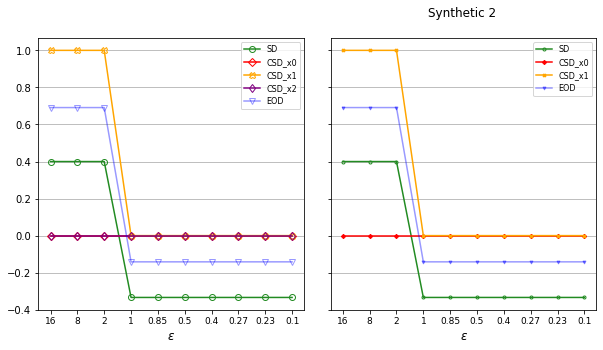

In [95]:
Make_subplots_2(lst_eps,'Synthetic4')